In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import metrics
from sklearn.decomposition import PCA
import math

**On a récupéré dans X_train, y_train, les pixels des 26 premières images et dans X_test, y_test, ceux des 4 dernières images. Seul un pixel sur 2000 a été conservé pour avoir des temps de calcul raisonnables.**

(1731, 2)
(639, 2)


<function matplotlib.pyplot.show>

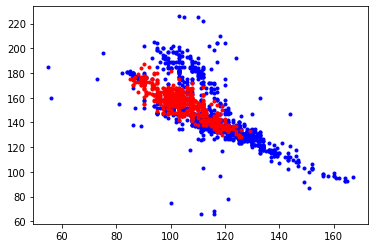

In [3]:
X_train, y_train, X_test, y_test = np.load("TP3.npy",allow_pickle=True )
#pixel peau
T_train = X_train[np.where(y_train==1),:] 
T_train = np.reshape(T_train,(T_train.shape[1],T_train.shape[2] ))

#pixel non peau
F_train = X_train[np.where(y_train==0),:] 
F_train = np.reshape(F_train,(F_train.shape[1],F_train.shape[2] ))

plt.plot(F_train[:,0], F_train[:,1], '.b') 
print(np.shape(F_train))
plt.show 
plt.plot(T_train[:,0], T_train[:,1], '.r') 
print(np.shape(T_train))
plt.show
#en rouge occurence pixel peau et en bleu occurence pixel non peau

In [4]:
print(y_train) # on remarque que y test ne possede que des val binaires 1 pour couleur peau, 0 sinon

[0 0 0 ... 1 0 0]


**Combien y a-t-il de pixels de teinte chaire ? de teinte non chaire ? Quelle est la dimension des données ?**

(1731, 2)
(639, 2)
Il y a 2370 pixels de dimension 2 
1731 pour F train -> pixel non peau avec y_test=0
639 pour T Train -> pixel peau avec y_test=1


## Estimation de la densité de probabilité a priori de la teinte chaire par une loi normale 2D avec des dimensions décorrélées

In [5]:
m1=np.mean(T_train[:,0])
m2=np.mean(T_train[:,1])
print(m1,m2)
std1=np.std(T_train[:,0])
std2=np.std(T_train[:,1])
print(std1,std2)

104.29577464788733 155.19405320813772
9.067914388009926 11.607693835769547


* m1 m2 moyenne de T_train des composantes chromatiques Cb et Cr de chaque pixel
* std1 et std2 ecart type de T_train de Cb et Cr de chaque pixel




In [0]:
def norm1(x,m,std):
  return (1/(np.sqrt(2*np.pi)*std))*np.exp(-((x-m)**2)/(2*std**2))

**norm1 fonction pour estimer la densité de probabilité a priori des pixels de teinte chaire de la base d’apprentissage en un point x**

In [0]:
P1_train=[]
for i in range(len(X_train)):
  P1_train.append(norm1(X_train[i,0],m1,std1)*norm1(X_train[i,1],m2,std2))

seuil=np.mean(P1_train)


Ici S correspondra à notre seuil, si le point x étudié n'a pas le bon seuil déterminé par Cb et Cr, il est assimilé à un pixel non chair ou chair dans l'autre cas

In [17]:
print(np.shape(P1_train))

(2370,)


**Que représentent TP, TN, FP et FN ? Comment estimer le rappel et la précision ? Comment estimer le taux de bonne classification ? Pourquoi avoir choisi ce seuil initial ?**

TP : pixel classe teinte chair etant teinte chair
TN:pixel classe non teinte chair etant non teinte chair
FP:pixel classe teinte chaire etant non teinte chair
FN : pixel classe non teinte chair etant teinte chair


In [18]:
print("TP : pixels couleur chair trouvés chair")
print("FN : pixels couleur chair trouvés non chair")
print("TN : pixels couleur non chair trouvés non chair")
print("TP : pixels couleur non chair trouvés chair")

length=len(X_train)
print("\n\nSeuil à  p = " +str(seuil) )

y_class = (P1_train > seuil)
print("y_res.shape = " + str(y_class.shape))



matrix = metrics.confusion_matrix(y_train , y_class)
print(matrix)
taux = np.trace(matrix) / np.sum(matrix)
print("\nTaux de reconnaissance : " + str(taux))

TP : pixels couleur chair trouvés chair
FN : pixels couleur chair trouvés non chair
TN : pixels couleur non chair trouvés non chair
TP : pixels couleur non chair trouvés chair


Seuil à  p = 0.0004021648006133216
y_res.shape = (2370,)
[[1344  387]
 [ 184  455]]

Taux de reconnaissance : 0.7590717299578059


* Un bon classificateur devra être •sensible : détecter les positifs = pourcentage de vrais positifs détectés
* •spécifique : ne pas tout détecter comme positif = pourcentage de vrais négatifs détectés

In [0]:
Max = np.max(P1_train)
ROCsensibilite=[]
ROCspecificite=[]
step = 100
ROC = np.ones([step , 2])
taux = np.ones(step)
arr = np.arange(0,Max,Max/step)

for i in range( step ):    
    
    seuil = arr[i] 
    y_class = (P1_train > seuil)
    matrix = metrics.confusion_matrix(y_train , y_class)
    taux = np.trace(matrix) / np.sum(matrix)
    specificite=matrix[1,1] / (matrix[1,0] + matrix[1,1])
    sensibilite= matrix[0,0] / (matrix[0,0] + matrix[0,1])

    taux=(TP+TN)/(TP+TN+FN+FP)
    ROCsensibilite.append(sensibilite)
    ROCspecificite.append(1-specificite)


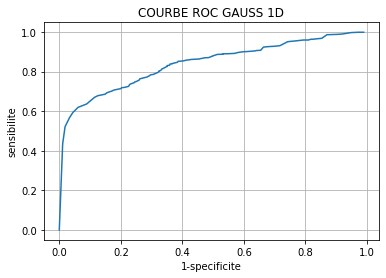

In [20]:
plt.plot_date
fig, ax = plt.subplots()
ax.plot(ROCspecificite,ROCsensibilite)

ax.set(xlabel='1-specificite', ylabel='sensibilite',
       title='COURBE ROC GAUSS 1D')
ax.grid()


on veut s'approcher du point 0,1



# loi normale 2D

In [0]:
def norm2(x, m, cov):
	  a = np.dot( np.transpose((x-m)), np.linalg.inv(cov) )
	  a = np.dot( a, (x-m) )
	  p = 1 / ( math.sqrt(2*math.pi*np.linalg.det(cov)) ) * math.exp( -0.5*a )
	  return p

In [0]:
length = len(X_train)
p2_train = np.ones([length])
i=0
while i < length : 
    X = X_train[i,:]
    p2_train[i] = norm2( X ,np.mean(T_train) ,  np.cov(T_train[:,0] , T_train[:,1]) )
    i +=1
    

#ici x et y seront corrélés et on va appliquer le traitement gaussien à deux dimensions

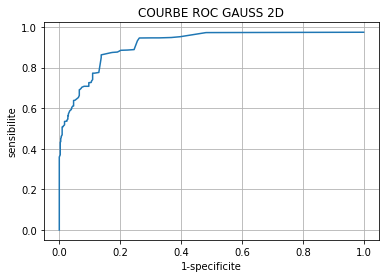

In [27]:
Max = np.max(p2_train)
ROCsensibilite2=[]
ROCspecificite2=[]
step = 100
ROC = np.ones([step , 2])
taux = np.ones(step)
arr = np.arange(0,Max,Max/step)
for i in range( step ):    
    
    seuil = arr[i] #variation du seuil de 0 à step
    y_class = (p2_train > seuil)
    matrix = metrics.confusion_matrix(y_train , y_class)
    taux = np.trace(matrix) / np.sum(matrix)
    specificite=matrix[1,1] / (matrix[1,0] + matrix[1,1])
    sensibilite= matrix[0,0] / (matrix[0,0] + matrix[0,1])

    taux=np.trace(matrix) / np.sum(matrix)
    ROCsensibilite2.append(sensibilite)
    ROCspecificite2.append(specificite)
plt.plot_date
fig, ax = plt.subplots()
ax.plot(ROCspecificite2,np.flipud(ROCsensibilite2))

ax.set(xlabel='1-specificite', ylabel='sensibilite',
       title='COURBE ROC GAUSS 2D')
ax.grid()
